In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf4
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from cftime import DatetimeNoLeap
import datetime as dt

# This entire block helps with relative imports
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from utils.processing import ibtracs_vars

#from sklearn.metrics.pairwise import euclidean_distances, haversine_distances
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss

from haversine import haversine_vector

In [2]:
def read_tempest_ASCII(file, colnames):
    
    # Reads in file
    df = pd.read_csv(file, sep='\s+', names=colnames)
    
    # Takes individual year, month, day, hour columns and transforms to pd.date_time column
    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    
    # Drops year, month, day, hour columns
    df = df[['time', 'lon_x', 'lat_y', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']]
    
    # Selects indices where a new track starts, assigns to array
    run_idx = df[df.lon_x=='start'].index.tolist()

    # Separates dataframe into individual dataframes, split on new tracks
    dfs = [df.iloc[run_idx[n]+1:run_idx[n+1]] for n in range(len(run_idx)-1)]
    
    # Drops lon_x and lat_y columns
    dfs = [dfi[['time', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']] for dfi in dfs]
    
    # Resets index from previous dataframe splits
    dfs = [dfi.reset_index(drop=True) for dfi in dfs]
    
    # Creates storm IDs
    for i, dfi in enumerate(dfs):
        dfi['tempest_ID'] = f'storm_{i}'
    
    # Merges dfs back together
    df_concat = pd.concat([dfi for dfi in dfs]).reset_index(drop=True)
    
    return df_concat

In [3]:
def read_tempest_csv(file):
    
    # Reads in file, swaps outrageous wind values with NaN
    df = pd.read_csv(file, na_values='14142.00000')
    
    # Strips leading space in most columns
    df = df.rename(columns=lambda x: x.strip())
    
    # Takes individual year, month, day, hour columns and transforms to pd.date_time column
    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    
    # Drops year, month, day, hour, i, j, and phis columns
    df = df[['track_id', 'time', 'lon', 'lat', 'slp', 'wind']]
    
    # Adds 'storm' as prefix to track_id
    df['track_id'] = df['track_id'] = 'storm_' + df['track_id'].astype(str)
    
    # Renames track_id column for processing with ibtracs
    df = df.rename(columns={'track_id':'tempest_ID'})
    
    return df

In [4]:
def match_tracks(tempest_track, ibtracs_df):
    
    merged = pd.merge(tempest_track, ibtracs_df, on='time')   # This is an inner merge by default (only matched tracks are kept)
    
    # to avoid pandas freaking out when trying to calculate haversine distance metric
    if merged.empty:
        return merged
    else:
        merged['dist_km'] = merged.apply(lambda x: haversine_vector((x.lat, x.lon),
                                                                 (x.LAT, x.LON), 
                                                                 unit='km')[0], axis=1).round(4)
        merged = merged[merged['dist_km'].apply(lambda x: x <= 300)].reset_index(drop=True)
        return merged
    
# Calculate hits to misses ratio (aim for ~70% match rate) - Done, see below

In [5]:
ERA5 = "../tempest_extremes/trajectories.txt.ERA5.csv"
NE30 = "../tempest_extremes/trajectories.csv.NE30"
preseek = "../tempest_extremes/trajectories.csv.ERA5.preseek"

ERA5_df = read_tempest_csv(ERA5)   # WSP in tempest is m/s
NE30_df = read_tempest_csv(NE30)
preseek_df = read_tempest_csv(preseek)

In [6]:
ERA5_df     # Note the crazy high wsp in rows 1, 2, and 4

,tempest_ID,time,lon,lat,slp,wind
0,storm_0,1980-01-06 06:00:00,120.50,-14.25,99876.38,14.64815
1,storm_0,1980-01-06 12:00:00,119.00,-14.75,99811.00,13.98848
2,storm_0,1980-01-06 18:00:00,119.00,-15.00,99536.94,13.69575
3,storm_0,1980-01-07 00:00:00,119.25,-15.00,99414.56,17.97812
4,storm_0,1980-01-07 06:00:00,119.50,-15.50,99173.19,17.22728
...,...,...,...,...,...,...
79128,storm_3084,2018-12-30 18:00:00,140.00,-12.75,99876.31,17.37369
79129,storm_3084,2018-12-31 00:00:00,138.75,-12.50,99872.75,17.45932
79130,storm_3084,2018-12-31 06:00:00,140.00,-12.25,99379.44,18.59908
79131,storm_3084,2018-12-31 12:00:00,140.25,-12.75,99771.50,17.96575


In [7]:
NE30_df

,tempest_ID,time,lon,lat,slp,wind
0,storm_0,1984-07-05 06:00:00,252.000000,17.969021,100694.3,6.541617
1,storm_0,1984-07-05 12:00:00,252.000000,17.969021,100514.9,7.336538
2,storm_0,1984-07-05 18:00:00,252.000000,19.258961,100466.5,9.863070
3,storm_0,1984-07-06 00:00:00,251.169748,19.173134,100243.9,11.609180
4,storm_0,1984-07-06 06:00:00,251.169748,19.173134,100260.6,13.658820
...,...,...,...,...,...,...
26227,storm_957,2005-12-27 00:00:00,71.170276,-14.230698,100414.4,8.905214
26228,storm_957,2005-12-27 06:00:00,69.828390,-14.117872,100530.3,7.932494
26229,storm_957,2005-12-27 12:00:00,69.000000,-14.826573,100513.9,9.734909
26230,storm_957,2005-12-28 00:00:00,66.828072,-15.859446,100611.6,10.181870


In [8]:
preseek_df     # Note the crazy high wsp in rows 1, 2, and 4
# This should match observed data

,tempest_ID,time,lon,lat,slp,wind
0,storm_0,1980-01-01 00:00:00,80.25,-14.75,100622.40,11.34231
1,storm_0,1980-01-01 06:00:00,79.50,-14.25,100806.80,NaN
2,storm_0,1980-01-01 12:00:00,78.75,-14.00,100644.10,NaN
3,storm_0,1980-01-01 18:00:00,78.00,-15.25,100878.20,11.97350
4,storm_0,1980-01-02 00:00:00,77.25,-13.00,100809.90,NaN
...,...,...,...,...,...,...
132489,storm_4416,2019-12-30 18:00:00,184.00,-21.25,98767.06,20.27008
132490,storm_4416,2019-12-31 00:00:00,185.00,-20.75,98946.00,19.50820
132491,storm_4416,2019-12-31 06:00:00,186.25,-20.75,99024.69,18.33595
132492,storm_4416,2019-12-31 12:00:00,187.25,-20.75,99052.31,18.33949


In [43]:
len(preseek_df['tempest_ID'].unique().tolist())

4417

In [9]:
# Note: last downloaded on May 23, 2022
# Will make a function that auto-pulls from NCEI later
ibtracs_csv = "../tempest_extremes/ibtracs.since1980.list.v04r00.csv"

# Non agency-specific ibtracs columns
storm_cols = ['SID', 'SEASON', 'NAME', 'ISO_TIME', 'NATURE', 'LAT', 'LON', 'TRACK_TYPE']

# Agency-specific pressure columns
pres_cols = ['USA_PRES', 'WMO_PRES','TOKYO_PRES', 'CMA_PRES','HKO_PRES', 'NEWDELHI_PRES', 
             'REUNION_PRES', 'BOM_PRES', 'NADI_PRES', 'WELLINGTON_PRES']

# Agency-specific max sustained wind speed columns
wsp_cols = ['WMO_WIND', 'USA_WIND', 'TOKYO_WIND', 'CMA_WIND', 'HKO_WIND', 'NEWDELHI_WIND', 
            'REUNION_WIND', 'BOM_WIND', 'NADI_WIND', 'WELLINGTON_WIND']

# All selected ibtracs cols
ibtracs_cols = storm_cols + pres_cols + wsp_cols
nans = ['', ' ', -999, -99]
ibtracs = pd.read_csv(ibtracs_csv, usecols=ibtracs_cols, skiprows=[1], 
                      dtype={'STORM_SPEED': np.float64, 'STORM_DIR': np.float64},
                      na_values=nans, parse_dates=['ISO_TIME'])

# Renames time column, this is for simplified merging later on (could use right_on/left_on, but I didn't)
ibtracs = ibtracs.rename(columns={'ISO_TIME':'time'})

# Makes "unclean" ibtracs
unclean_ibtracs = ibtracs.copy(deep=True)

# Drop anything that's not 0Z, 6Z, 12Z, or 18Z hour intervals
ibtracs = ibtracs[ibtracs['time'].apply(lambda x: x.hour in([0, 6, 12, 18]))].reset_index(drop=True)

# Drop anything non-tropical
# Possibly comment out this filter ?
ibtracs = ibtracs[ibtracs['NATURE']=='TS']

# Drop 'spur' tracks (where the ibtracs algo confuses different tracks for the same storm)
ibtracs = ibtracs[ibtracs['TRACK_TYPE']=='main'].reset_index(drop=True)

# Drop rows without WMO data
ibtracs = ibtracs.dropna(subset=['WMO_PRES', 'WMO_WIND']).reset_index(drop=True)

# Creates one pressure column based on Stella's code (prioritizes WMO values, 
# otherwise averages over other agency pressure cols)
ibtracs['PRES'] = np.where(~ibtracs.WMO_PRES.isna(), ibtracs.WMO_PRES, 
                           ibtracs[pres_cols].mean(axis=1, skipna=True))

# Converts pressure from mb/hPa to Pa
ibtracs['PRES'] = ibtracs['PRES'].mul(100)

# From Knapp and Kruk (2010) method for adjusting interagency wsp to 1-min sustained
# https://doi.org/10.1175/2009MWR3123.1
ibtracs['TOKYO_WIND_1'] = ibtracs.apply(lambda x: ((x['TOKYO_WIND'] - 23.3)/0.60), axis=1)
ibtracs['CMA_WIND_1'] = ibtracs['CMA_WIND'].div(0.871)
ibtracs['HKO_WIND_1'] = ibtracs['HKO_WIND'].div(0.9)
ibtracs['NEWDELHI_WIND_1'] = ibtracs['NEWDELHI_WIND']
ibtracs['REUNION_WIND_1'] = ibtracs['REUNION_WIND'].div(0.88)
ibtracs['BOM_WIND_1'] = ibtracs['BOM_WIND'].div(0.88)
ibtracs['NADI_WIND_1'] = ibtracs['NADI_WIND'].div(0.88)
ibtracs['WELLINGTON_WIND_1'] = ibtracs['WELLINGTON_WIND'].div(0.88)
ibtracs['USA_WIND_1'] = ibtracs['USA_WIND']

# Creates one wsp column
ibtracs['wsp_kts'] = ibtracs.filter(like='WIND_1').ffill(axis=1).iloc[:,-1]

# Converts wsp column to m/s
ibtracs['WSP'] = ibtracs['wsp_kts'].mul(0.514)

# Drops all extra pressure columns
ibtracs = ibtracs[['SID', 'SEASON', 'NAME', 'time', 'LAT', 'LON', 'PRES', 'WSP']]

clean_ibtracs = ibtracs.copy()
clean_ibtracs

# Use unclean ibtracs for track comparison, false alarms, and hits calculations
# Use clean ibtracs data for misses

,SID,SEASON,NAME,time,LAT,LON,PRES,WSP
0,1980001S13173,1980,PENI,1980-01-02 00:00:00,-11.1882,173.00,99700.0,15.42
1,1980001S13173,1980,PENI,1980-01-02 12:00:00,-12.0000,173.50,99000.0,17.99
2,1980001S13173,1980,PENI,1980-01-03 00:00:00,-13.0000,174.40,98500.0,17.99
3,1980001S13173,1980,PENI,1980-01-03 12:00:00,-15.0000,174.96,97000.0,25.70
4,1980001S13173,1980,PENI,1980-01-04 00:00:00,-17.5000,175.80,98700.0,33.41
...,...,...,...,...,...,...,...,...
73783,2021311N13248,2021,SANDRA,2021-11-08 12:00:00,14.4000,-116.60,100600.0,17.99
73784,2021311N13248,2021,SANDRA,2021-11-08 18:00:00,14.9000,-117.30,100800.0,15.42
73785,2021311N13248,2021,SANDRA,2021-11-09 00:00:00,15.1000,-118.20,100800.0,15.42
73786,2021311N13248,2021,SANDRA,2021-11-09 06:00:00,15.0000,-119.10,100900.0,12.85


In [10]:
unclean_ibtracs

,SID,SEASON,NAME,time,NATURE,LAT,LON,WMO_WIND,WMO_PRES,TRACK_TYPE,...,NEWDELHI_WIND,NEWDELHI_PRES,REUNION_WIND,REUNION_PRES,BOM_WIND,BOM_PRES,NADI_WIND,NADI_PRES,WELLINGTON_WIND,WELLINGTON_PRES
0,1980001S13173,1980,PENI,1980-01-01 00:00:00,TS,-12.5000,172.500,NaN,NaN,main,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980001S13173,1980,PENI,1980-01-01 03:00:00,TS,-12.1927,172.441,NaN,NaN,main,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980001S13173,1980,PENI,1980-01-01 06:00:00,TS,-11.9144,172.412,NaN,NaN,main,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980001S13173,1980,PENI,1980-01-01 09:00:00,TS,-11.6863,172.435,NaN,NaN,main,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980001S13173,1980,PENI,1980-01-01 12:00:00,TS,-11.5000,172.500,NaN,NaN,main,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280043,2022139S15169,2022,GINA,2022-05-21 12:00:00,NR,-20.8000,170.800,NaN,NaN,PROVISIONAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280044,2022139S15169,2022,GINA,2022-05-21 15:00:00,NR,-20.7147,171.003,NaN,NaN,PROVISIONAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280045,2022139S15169,2022,GINA,2022-05-21 18:00:00,NR,-20.6000,171.100,NaN,NaN,PROVISIONAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280046,2022139S15169,2022,GINA,2022-05-21 21:00:00,NR,-20.5327,171.270,NaN,NaN,PROVISIONAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
clean_ibtracs

,SID,SEASON,NAME,time,LAT,LON,PRES,WSP
0,1980001S13173,1980,PENI,1980-01-02 00:00:00,-11.1882,173.00,99700.0,15.42
1,1980001S13173,1980,PENI,1980-01-02 12:00:00,-12.0000,173.50,99000.0,17.99
2,1980001S13173,1980,PENI,1980-01-03 00:00:00,-13.0000,174.40,98500.0,17.99
3,1980001S13173,1980,PENI,1980-01-03 12:00:00,-15.0000,174.96,97000.0,25.70
4,1980001S13173,1980,PENI,1980-01-04 00:00:00,-17.5000,175.80,98700.0,33.41
...,...,...,...,...,...,...,...,...
73783,2021311N13248,2021,SANDRA,2021-11-08 12:00:00,14.4000,-116.60,100600.0,17.99
73784,2021311N13248,2021,SANDRA,2021-11-08 18:00:00,14.9000,-117.30,100800.0,15.42
73785,2021311N13248,2021,SANDRA,2021-11-09 00:00:00,15.1000,-118.20,100800.0,15.42
73786,2021311N13248,2021,SANDRA,2021-11-09 06:00:00,15.0000,-119.10,100900.0,12.85


In [12]:
# Need to split tempest df based on track ID
te_tracks_ERA5 = ERA5_df['tempest_ID'].unique().tolist()
ERA5_matched_dfs = [match_tracks(ERA5_df.loc[ERA5_df['tempest_ID']==te_tracks_ERA5[i]], 
                            unclean_ibtracs) for i in range(len(te_tracks_ERA5))]

te_tracks_NE30 = NE30_df['tempest_ID'].unique().tolist()
NE30_matched_dfs = [match_tracks(NE30_df.loc[NE30_df['tempest_ID']==te_tracks_NE30[i]], 
                            unclean_ibtracs) for i in range(len(te_tracks_NE30))]

te_tracks_preseek = preseek_df['tempest_ID'].unique().tolist()
preseek_matched_dfs = [match_tracks(preseek_df.loc[preseek_df['tempest_ID']==te_tracks_preseek[i]], 
                            unclean_ibtracs) for i in range(len(te_tracks_preseek))]

In [15]:
def matched_tracks(matched_dfs, unclean_ib=True):

    matched_df = pd.concat([df for df in matched_dfs]).reset_index(drop=True)

    if unclean_ib == False:
        # Fixes weird repeating decimal for pressure (consequence of tempest.wsp sig figs, probably)
        matched_df['PRES'] = matched_df['PRES'].round(2)

    # Moves tempest_ID column up to more easily differentiate between tempest (lowercase) and ibtracs (uppercase) cols
    matched_cols = matched_df.columns.tolist()
    matched_cols = [matched_cols[0]] + [matched_cols[6]] + matched_cols[1:6] + matched_cols[7:]
    matched_df = matched_df[matched_cols]

    return matched_df

In [16]:
matched_ERA5 = matched_tracks(ERA5_matched_dfs)
matched_NE30 = matched_tracks(NE30_matched_dfs)
matched_preseek = matched_tracks(preseek_matched_dfs)

In [17]:
matched_ERA5

,tempest_ID,SID,time,lon,lat,slp,wind,SEASON,NAME,NATURE,...,NEWDELHI_PRES,REUNION_WIND,REUNION_PRES,BOM_WIND,BOM_PRES,NADI_WIND,NADI_PRES,WELLINGTON_WIND,WELLINGTON_PRES,dist_km
0,storm_0,1980005S14120,1980-01-06 06:00:00,120.50,-14.25,99876.38,14.64815,1980,AMY,TS,...,NaN,NaN,NaN,50.0,980.0,NaN,NaN,NaN,NaN,204.0115
1,storm_0,1980005S14120,1980-01-06 12:00:00,119.00,-14.75,99811.00,13.98848,1980,AMY,TS,...,NaN,NaN,NaN,55.0,975.0,NaN,NaN,NaN,NaN,64.2621
2,storm_0,1980005S14120,1980-01-06 18:00:00,119.00,-15.00,99536.94,13.69575,1980,AMY,TS,...,NaN,NaN,NaN,60.0,970.0,NaN,NaN,NaN,NaN,63.6977
3,storm_0,1980005S14120,1980-01-07 00:00:00,119.25,-15.00,99414.56,17.97812,1980,AMY,TS,...,NaN,NaN,NaN,65.0,965.0,NaN,NaN,NaN,NaN,92.5186
4,storm_0,1980005S14120,1980-01-07 06:00:00,119.50,-15.50,99173.19,17.22728,1980,AMY,TS,...,NaN,NaN,NaN,70.0,959.0,NaN,NaN,NaN,NaN,129.3509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69729,storm_3084,2018363S12145,2018-12-30 18:00:00,140.00,-12.75,99876.31,17.37369,2019,PENNY,TS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.7831
69730,storm_3084,2018363S12145,2018-12-31 00:00:00,138.75,-12.50,99872.75,17.45932,2019,PENNY,TS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.2396
69731,storm_3084,2018363S12145,2018-12-31 06:00:00,140.00,-12.25,99379.44,18.59908,2019,PENNY,TS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.8305
69732,storm_3084,2018363S12145,2018-12-31 12:00:00,140.25,-12.75,99771.50,17.96575,2019,PENNY,TS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5391


In [18]:
#matched_ERA5[(matched_ERA5['NAME']=='KATRINA') & (matched_ERA5['SEASON']==2005)]


In [19]:
print('Matched ERA5 tracks: ', len(matched_ERA5['tempest_ID'].unique().tolist()))
print('Matched NE30 tracks: ', len(matched_NE30['tempest_ID'].unique().tolist()))
print('Matched Preseek tracks: ', len(matched_preseek['tempest_ID'].unique().tolist()))

Matched ERA5 tracks:  2668
Matched NE30 tracks:  911
Matched Preseek tracks:  4383


In [14]:
mean_dist = matched_df.groupby('SID')['dist_km'].mean()
#fig, ax = plt.subplots(figsize=[10, 5], dpi=300)

#ax.scatter(matched_df['SID'].unique().tolist(), mean_dist)
#plt.show()

In [39]:
#matched_df.groupby(['tempest_ID'])['PRES'].mean().values
#matched_df.groupby(['tempest_ID'])['slp'].mean().values
#matched_df[matched_df['WSP'].isna()]

In [38]:
print('Average Distance between TE/IB: ', matched_df['dist_km'].mean().round(2), 'km')

Average Distance between TE/IB:  53.92 km


## Hit Rate

In [21]:
# Use unclean ibtracs for track comparison, false alarms, and hits calculations
# Use clean ibtracs data for misses

def hit_to_fa(tempest_track, unclean_ibtracs_df):
    merged = pd.merge(tempest_track, unclean_ibtracs_df, on='time')
    if merged.empty:
        return 'false alarm'
    else:
        merged['dist_km'] = merged.apply(lambda x: haversine_vector((x.lat, x.lon),
                                                                 (x.LAT, x.LON), 
                                                                 unit='km')[0], axis=1).round(4)
        merged = merged[merged['dist_km'].apply(lambda x: x <= 300)].reset_index(drop=True)
        if merged.empty:
            return 'false alarm'
        else:
            return 'hit'
        
def far(hit_fa_array):
    
    hits = np.char.count(hit_fa_array, 'hit').sum()
    false_alarms = np.char.count(hit_fa_array, 'false alarm').sum()

    # False alarm rate (Stella)
    far = false_alarms/(hits+false_alarms)
    
    return far


In [23]:
# Subsets ibtracs for NE30 comparison (1984-2005)
start_yr = NE30_df['time'].iloc[0].year
end_yr = NE30_df['time'].iloc[-1].year
unclean_ibtracs_30 = unclean_ibtracs[unclean_ibtracs['time'].apply(lambda x: (x.year >= start_yr) &\
                                                                   (x.year <= end_yr))].reset_index(drop=True)
clean_ibtracs_30 = clean_ibtracs[clean_ibtracs['time'].apply(lambda x: (x.year >= start_yr) &\
                                                             (x.year <= end_yr))].reset_index(drop=True)

# Calculates hit/false alarm rate (tempest tracks present in ibtracs)
ERA5_hit_to_fa = [hit_to_fa(ERA5_df.loc[ERA5_df['tempest_ID']==te_tracks_ERA5[i]], 
                            unclean_ibtracs) for i in range(len(te_tracks_ERA5))]
NE30_hit_to_fa = [hit_to_fa(NE30_df.loc[NE30_df['tempest_ID']==te_tracks_NE30[i]], 
                            unclean_ibtracs_30) for i in range(len(te_tracks_NE30))]
preseek_hit_to_fa = [hit_to_fa(preseek_df.loc[preseek_df['tempest_ID']==te_tracks_preseek[i]], 
                            unclean_ibtracs) for i in range(len(te_tracks_preseek))]

ERA5_far = far(ERA5_hit_to_fa)
NE30_far = far(NE30_hit_to_fa)
preseek_far = far(preseek_hit_to_fa)

print('ERA5 False Alarm Rate: ', (ERA5_far*100).round(2), '%')
print('NE30 False Alarm Rate: ', (NE30_far*100).round(2), '%')
print('Preseek False Alarm Rate: ', (preseek_far*100).round(2), '%')


ERA5 False Alarm Rate:  13.52 %
NE30 False Alarm Rate:  4.91 %
Preseek False Alarm Rate:  0.77 %


In [ ]:
# This is after editing ibtracs parameters

# Plot where FAs are to see if there's a southern hemisphere bias
def check_FA_bias(tempest_df, hit_to_fa_arr):
    tracks_arr = tempest_df['tempest_ID'].unique().tolist()
    df = pd.DataFrame([tracks_arr, hit_to_fa_arr]).T
    df.columns = ['tempest_ID', 'hit/fa']
    merged_df = pd.merge(df, tempest_df, on='tempest_ID', how='outer')
    return merged_df

preseek_bias = check_FA_bias(preseek_df, preseek_hit_to_fa)
ERA5_bias = check_FA_bias(ERA5_df, ERA5_hit_to_fa)
NE30_bias = check_FA_bias(NE30_df, NE30_hit_to_fa)

proj=ccrs.PlateCarree(globe=None)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,15), dpi=200, subplot_kw=dict(projection=proj))
for ax in axs:
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
sns.scatterplot(data=preseek_bias[preseek_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[0], s=3)
axs[0].set_title('Preseek False Alarms')
sns.scatterplot(data=ERA5_bias[ERA5_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[1], s=3)
axs[1].set_title('ERA5 False Alarms')
sns.scatterplot(data=NE30_bias[NE30_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[2], s=3)
axs[2].set_title('NE30 False Alarms')
#sns.scatterplot(data=preseek_bias, ax=ax, x='lon', y='lat', hue='hit/fa', s=2)

#preseek_bias.plot.scatter(ax=ax, x='lon', y='lat', c='hit/fa', colormap='viridis')
fig.tight_layout()
plt.show()

In [ ]:
# This is before editing ibtracs params

# Plot where FAs are to see if there's a southern hemisphere bias
def check_FA_bias(tempest_df, hit_to_fa_arr):
    tracks_arr = tempest_df['tempest_ID'].unique().tolist()
    df = pd.DataFrame([tracks_arr, hit_to_fa_arr]).T
    df.columns = ['tempest_ID', 'hit/fa']
    merged_df = pd.merge(df, tempest_df, on='tempest_ID', how='outer')
    return merged_df

preseek_bias = check_FA_bias(preseek_df, preseek_hit_to_fa)
ERA5_bias = check_FA_bias(ERA5_df, ERA5_hit_to_fa)
NE30_bias = check_FA_bias(NE30_df, NE30_hit_to_fa)

proj=ccrs.PlateCarree(globe=None)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,15), dpi=200, subplot_kw=dict(projection=proj))
for ax in axs:
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
sns.scatterplot(data=preseek_bias[preseek_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[0], s=3)
axs[0].set_title('Preseek False Alarms')
sns.scatterplot(data=ERA5_bias[ERA5_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[1], s=3)
axs[1].set_title('ERA5 False Alarms')
sns.scatterplot(data=NE30_bias[NE30_bias['hit/fa']=='false alarm'], x='lon', y='lat', ax=axs[2], s=3)
axs[2].set_title('NE30 False Alarms')
#sns.scatterplot(data=preseek_bias, ax=ax, x='lon', y='lat', hue='hit/fa', s=2)

#preseek_bias.plot.scatter(ax=ax, x='lon', y='lat', c='hit/fa', colormap='viridis')
fig.tight_layout()
plt.show()

In [27]:
# Use unclean ibtracs for track comparison, false alarms, and hits calculations
# Use clean ibtracs data for misses

def hit_to_miss(clean_ibtracs_track, tempest_df):
    merged = pd.merge(clean_ibtracs_track, tempest_df, on='time')
    if merged.empty:
        return 'miss'
    else:
        merged['dist_km'] = merged.apply(lambda x: haversine_vector((x.lat, x.lon),
                                                                 (x.LAT, x.LON), 
                                                                 unit='km')[0], axis=1).round(4)
        merged = merged[merged['dist_km'].apply(lambda x: x <= 300)].reset_index(drop=True)
        if merged.empty:
            return 'miss'
        else:
            return 'hit'
        
def pod(hit_miss_array, hit_fa_array):
    
    hits = np.char.count(hit_fa_array, 'hit').sum()
    misses = np.char.count(hit_miss_array, 'miss').sum()

    # Probability of detection (Stella)
    pod = hits/(hits+misses)
    
    return pod

In [28]:
clean_ibtracs_30 = clean_ibtracs[clean_ibtracs['time'].apply(lambda x: (x.year >= start_yr) &\
                                                             (x.year <= end_yr))].reset_index(drop=True)

# Need to split ibtracs df on each track
clean_ibtracs_storms = clean_ibtracs['SID'].unique().tolist()
clean_ibtracs_storms_30 = clean_ibtracs_30['SID'].unique().tolist()    # For NE30 dataset

# Calculates hit/false alarm rate (tempest tracks present in ibtracs)
ERA5_hit_miss_array = [hit_to_miss(clean_ibtracs.loc[clean_ibtracs['SID']==clean_ibtracs_storms[i]], 
                            ERA5_df) for i in range(len(clean_ibtracs_storms))]
NE30_hit_miss_array = [hit_to_miss(clean_ibtracs_30.loc[clean_ibtracs['SID']==clean_ibtracs_storms_30[i]], 
                            NE30_df) for i in range(len(clean_ibtracs_storms_30))]
preseek_hit_miss_array = [hit_to_miss(clean_ibtracs.loc[clean_ibtracs['SID']==clean_ibtracs_storms[i]], 
                            preseek_df) for i in range(len(clean_ibtracs_storms))]

ERA5_pod = pod(ERA5_hit_miss_array, ERA5_hit_to_fa)
NE30_pod = pod(NE30_hit_miss_array, NE30_hit_to_fa)
preseek_pod = pod(preseek_hit_miss_array, preseek_hit_to_fa)

print('ERA5 Probability of Detection: ', (ERA5_pod*100).round(2), '%')
print('NE30 Probability of Detection: ', (NE30_pod*100).round(2), '%')
print('Preseek Probability of Detection: ', (preseek_pod*100).round(2), '%')

# Hits are ibracs tracks present in tempest
# Misses are ibtracks tracks NOT in tempest
# False alarms are tracks present in tempest but not in ibtracs

ERA5 Probability of Detection:  73.58 %
NE30 Probability of Detection:  61.47 %
Preseek Probability of Detection:  96.75 %


## Skill Metrics

### Root Mean Square Error

In [53]:
# This block calculated root mean square error and I'm confused by the values
# Only one NaN, which is genesis WSP for GYAN, 1982. Used 0 m/s instead of NaN.

def normalize(array):
    normalized = (array - array.min()) / (array.max() - array.min())
    return normalized

def rmsq(ibtracs_arr, te_arr):
    return mean_squared_error(ibtracs_arr, te_arr, squared=False)


In [54]:
ERA5_wsp_rmsq = rmsq(np.nan_to_num(matched_ERA5['WSP'].values), matched_ERA5['wind'].values)
ERA5_slp_rmsq = rmsq(matched_ERA5['PRES'].values, matched_ERA5['slp'].values)

NE30_wsp_rmsq = rmsq(matched_NE30['WSP'].values, matched_NE30['wind'].values)
NE30_slp_rmsq = rmsq(matched_NE30['PRES'].values, matched_NE30['slp'].values)

preseek_wsp_rmsq = rmsq(np.nan_to_num(matched_preseek['WSP'].values), np.nan_to_num(matched_preseek['wind'].values))
preseek_slp_rmsq = rmsq(matched_preseek['PRES'].values, matched_preseek['slp'].values)

# Implement a bias (see if mean of distribution lies on 0)


# norm_te_pres = normalize(matched_df['slp'].values)
# norm_ib_pres = normalize(matched_df['PRES'].values)

# norm_te_wsp = normalize(matched_df['wsp'].values)
# norm_ib_wsp = normalize(np.nan_to_num(matched_df['WSP'].values))

# te_slp_rmsq = mean_squared_error(norm_ib_pres, norm_te_pres, squared=False)
# te_wsp_rmsq = mean_squared_error(norm_ib_wsp, norm_te_wsp, squared=False)

# print('Normalized RMSE for SLP: ', te_slp_rmsq.round(4))
# print('Normalized RMSE for WSP: ', te_wsp_rmsq.round(4))

In [55]:
metrics_cols = ['ERA5', 'NE30', 'Preseek']
metrics_index = ['FAR', 'PoD', 'WSP RMSQ', 'SLP RMSQ']
fars = [ERA5_far, NE30_far, preseek_far]
pod = [ERA5_pod, NE30_pod, preseek_pod]
wsp_rmsq = [ERA5_wsp_rmsq, NE30_wsp_rmsq, preseek_wsp_rmsq]
slp_rmsq = [ERA5_slp_rmsq, NE30_slp_rmsq, preseek_slp_rmsq]
        
pd.DataFrame([fars, pod, wsp_rmsq, slp_rmsq], columns=metrics_cols, index=metrics_index).T       
        

,FAR,PoD,WSP RMSQ,SLP RMSQ
ERA5,0.240194,0.708991,18.498634,2218.891009
NE30,0.132568,0.667055,23.488277,3001.831867
Preseek,0.277111,0.955346,17.052442,1999.497323


In [46]:
#mean_squared_error(matched_df['PRES'].values, matched_df['slp'].values, squared=False)

# Filter by ibtracs < 970mb
# Do a scatter plot of RMSE x LMI (lifetime max intensity, max WSP or min SLP)
mean_squared_error(np.nan_to_num(matched_df['WSP'].values), matched_df['wsp'].values, squared=False)


18.49863417704418

In [35]:
# RMSE for each storm, averaged
norm_te_pres_avg = normalize(matched_df.groupby(['tempest_ID'])['slp'].mean().values)
norm_ib_pres_avg = normalize(matched_df.groupby(['tempest_ID'])['PRES'].mean().values)

norm_te_wsp_avg = normalize(matched_df['wsp'].values)
norm_ib_wsp_avg = normalize(np.nan_to_num(matched_df['WSP'].values))

te_slp_rmsq_per_storm = mean_squared_error(norm_ib_pres_avg, norm_te_pres_avg, squared=False)
te_wsp_rmsq_per_storm = mean_squared_error(norm_ib_wsp_avg, norm_te_wsp_avg, squared=False)

print('RMSE for SLP (per storm avg): ', te_slp_rmsq_per_storm.mean().round(4))
print('RMSE for WSP (per storm avg): ', te_wsp_rmsq_per_storm.mean().round(4))

RMSE for SLP (per storm avg):  0.1457
RMSE for WSP (per storm avg):  0.1301


In [43]:
#brier_score_loss(norm_ib_pres, norm_te_pres)

### \$R^2$ Scores

In [21]:
print('R2 for SLP: ', r2_score(norm_ib_pres, norm_te_pres).round(4))
print('R2 for WSP: ', r2_score(norm_ib_wsp, norm_te_wsp).round(4))
print('R2 for SLP (per storm avg): ', r2_score(norm_ib_pres_avg, norm_te_pres_avg).mean().round(4))
print('R2 for WSP (per storm avg): ', r2_score(norm_ib_wsp_avg, norm_te_wsp_avg).mean().round(4))

R2 for SLP:  0.2817
R2 for WSP:  0.3044
R2 for SLP (per storm avg):  0.202
R2 for WSP (per storm avg):  0.3044


In [195]:
#matched_df[matched_df['track_ID']=='storm_0']
matched_df[(matched_df['NAME']=='FLORENCE') & (matched_df['SEASON']==2018)]

,time,tempest_ID,lon,lat,slp,wsp,sfc_phi,SID,SEASON,NAME,LAT,LON,PRES,WSP,dist_km
50241,2018-08-31 18:00:00,storm_3044,336.25,14.50,100423.90,12.445280,0.000,2018242N13343,2018,FLORENCE,13.8,-23.8,100600.0,15.42,78.0230
50242,2018-09-01 00:00:00,storm_3044,335.25,14.00,100369.00,14.631990,0.000,2018242N13343,2018,FLORENCE,14.0,-24.9,100600.0,15.42,16.1838
50243,2018-09-01 06:00:00,storm_3044,333.50,14.50,100093.10,15.325010,0.000,2018242N13343,2018,FLORENCE,14.3,-26.1,100500.0,17.99,48.4821
50244,2018-09-01 12:00:00,storm_3044,332.50,14.75,100305.00,14.111460,0.000,2018242N13343,2018,FLORENCE,14.8,-27.2,100400.0,17.99,32.7312
50245,2018-09-01 18:00:00,storm_3044,331.25,15.25,100153.90,13.817740,0.000,2018242N13343,2018,FLORENCE,15.4,-28.3,100200.0,20.56,51.0596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50302,2018-09-16 00:00:00,storm_3044,279.75,33.50,99857.88,15.568180,235.440,2018242N13343,2018,FLORENCE,33.6,-80.2,99800.0,23.13,12.0463
50303,2018-09-16 06:00:00,storm_3044,279.00,33.50,100028.00,14.223760,819.135,2018242N13343,2018,FLORENCE,33.6,-80.8,99900.0,20.56,21.6138
50304,2018-09-16 12:00:00,storm_3044,278.50,33.50,100312.80,10.881770,1157.580,2018242N13343,2018,FLORENCE,33.6,-81.5,100200.0,17.99,11.1195
50305,2018-09-16 18:00:00,storm_3044,277.75,34.00,100628.80,7.355794,1608.840,2018242N13343,2018,FLORENCE,34.1,-82.1,100600.0,15.42,17.7377


ValueError: min() arg is an empty sequence

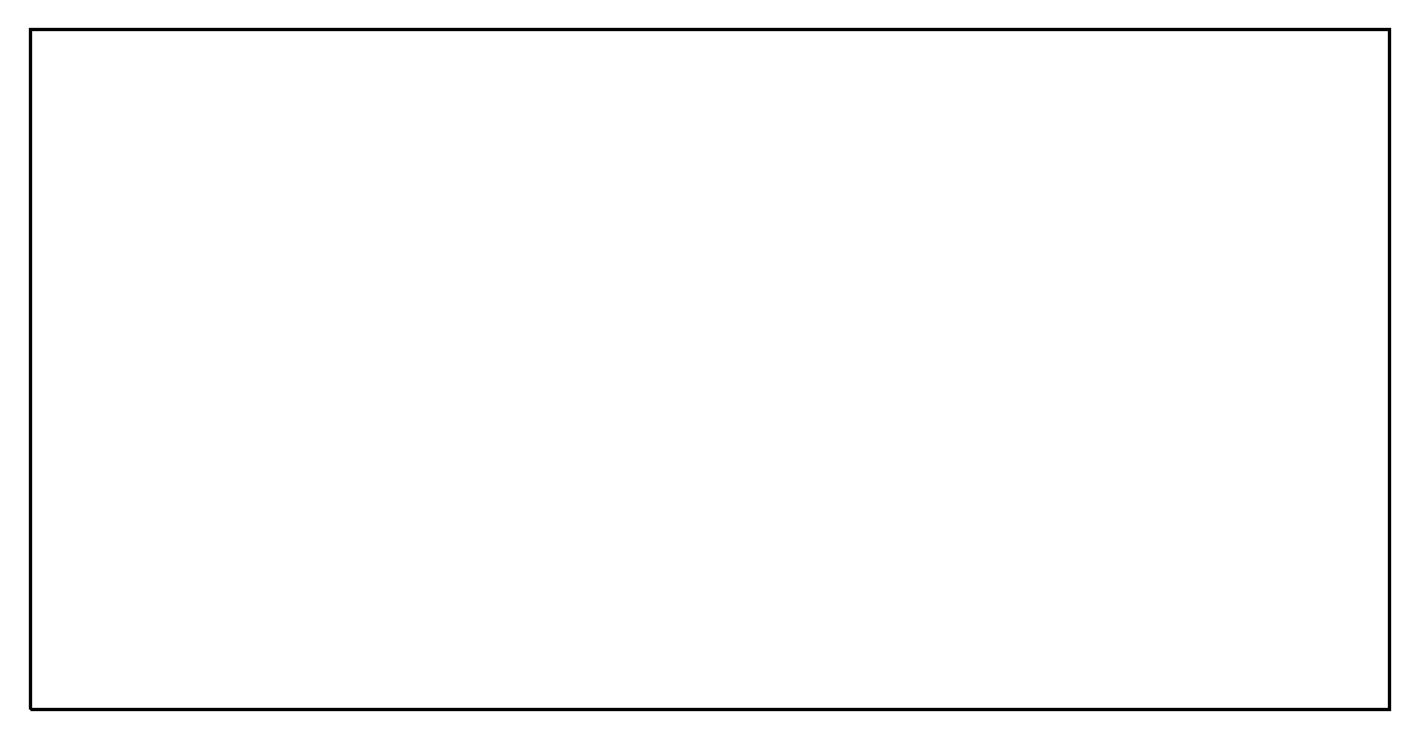

In [68]:
def plot_background(xmin, xmax, ymin, ymax, ax):
    ax.set_extent([xmin-5, xmax+5, ymin-5, ymax+5])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.25)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

#data = matched_df
data = matched_preseek[(matched_preseek['tempest_ID']=='storm_0')]
lats = data.lat.values
lons = data.lon.values

# Set up figure, basemap, etc.
proj=ccrs.PlateCarree(globe=None)
fig, ax = plt.subplots(figsize=(7,3), dpi=300, subplot_kw=dict(projection=proj))
plot_background(min(lons), max(lons), min(lats), max(lats), ax)

data.plot.scatter(x='lon', y='lat', transform=proj, ax=ax)
data.plot.scatter(x='LON', y='LAT', transform=proj, ax=ax, c='deeppink')
plt.show()


In [68]:
ibtracs_full = pd.read_csv(ibtracs_csv)
ibtracs_full.columns.values

/Users/cnd5285/opt/anaconda3/envs/geocat/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,8,9,14,19,20,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


array(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'WMO_AGENCY',
       'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG', 'USA_AGENCY',
       'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_RECORD', 'USA_STATUS',
       'USA_WIND', 'USA_PRES', 'USA_SSHS', 'USA_R34_NE', 'USA_R34_SE',
       'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE',
       'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE',
       'USA_R64_SW', 'USA_R64_NW', 'USA_POCI', 'USA_ROCI', 'USA_RMW',
       'USA_EYE', 'TOKYO_LAT', 'TOKYO_LON', 'TOKYO_GRADE', 'TOKYO_WIND',
       'TOKYO_PRES', 'TOKYO_R50_DIR', 'TOKYO_R50_LONG', 'TOKYO_R50_SHORT',
       'TOKYO_R30_DIR', 'TOKYO_R30_LONG', 'TOKYO_R30_SHORT', 'TOKYO_LAND',
       'CMA_LAT', 'CMA_LON', 'CMA_CAT', 'CMA_WIND', 'CMA_PRES', 'HKO_LAT',
       'HKO_LON', 'HKO_CAT', 'HKO_WIND', 'HKO_PRES', 'NEWDELHI_LAT',
       'NEWDELHI_LON', 'NEWDELHI_GRADE', 'NEWDELHI_WIND', 'NEWDELHI_PRES',
      

In [ ]:
# Short-term:
# Start looking at spatial error, distance at same time point between ibtracs/tempest
# Start looking at other error metrics (SLP, etc.) - Done ?
# Prioritize WMO pressure (throw out if no WMO data) - Done
# Error as function of obs pressure bounds

# Long-term:
# Pressure/wind relationship
# Inflow angle

In [ ]:
# Due by next meeting:
# 1) hit rate
# 2) skill metrics

# 3) in tempest: modify a couple things to see how tempest finds tracks